In [43]:
# 1. Imports & Paths
import importlib.util
import os, sys, re, pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed


sys.path.append(os.path.join(os.pardir, "utils"))

DATA_DIR = os.path.join(os.pardir, "data/clusters")
resume_path = os.path.join(DATA_DIR, "resumes_clustered.csv")
jobs_path   = os.path.join(DATA_DIR, "jobs_clustered.csv")


EMB_DIR = os.path.join(os.pardir, "data/embeddings")
remb_path = os.path.join(EMB_DIR, "resume_embeddings.npy")
jemb_path   = os.path.join(EMB_DIR, "job_embeddings.npy")
SAVE_DIR = os.path.join(os.pardir, "data/embeddings")

In [44]:
%load_ext autoreload
%autoreload 2
from utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
resume_df = pd.read_csv(resume_path)
job_posts_df = pd.read_csv(jobs_path)

resume_df = resume_df[["ID", "Resume_clean"]]
job_posts_df = job_posts_df[["job_text_clean"]]

resume_embeddings = np.load(remb_path)
job_embeddings = np.load(jemb_path)

In [46]:
for j_idx, job_vec in enumerate(job_embeddings):
    # Compute similarity between this job and all resumes
    sims = cosine_similarity([job_vec], resume_embeddings)[0]
    
    # Get top 5 most similar resumes
    top_idx = sims.argsort()[-5:][::-1]  # highest 5 cosine scores

    for r_idx in top_idx:
        pairs.append({
            "job_idx": j_idx,
            "resume_idx": r_idx,
            "cosine_similarity": sims[r_idx]
        })

pairs_df = pd.DataFrame(pairs)
# pairs_df.to_csv("job_resume_cosine_pairs.csv", index=False)
# print(f"✅ Saved {len(pairs_df):,} job–resume pairs")
pairs_df.head()

,resume_idx,job_idx,cosine_similarity
0,0,3321,0.833665
1,0,2856,0.813166
2,0,3160,0.808948
3,0,2403,0.802101
4,0,2937,0.790419


In [47]:
pairs_df

,resume_idx,job_idx,cosine_similarity
0,0,3321,0.833665
1,0,2856,0.813166
2,0,3160,0.808948
3,0,2403,0.802101
4,0,2937,0.790419
...,...,...,...
94135,553,5447,0.666872
94136,1929,5447,0.648839
94137,1299,5447,0.645512
94138,581,5447,0.640185


In [48]:
resumes = pd.read_csv(resume_path)
jobs= pd.read_csv(jobs_path)

In [49]:
# Merge resume text
pairs_df["resume_text"] = pairs_df["resume_idx"].apply(lambda i: resumes.loc[i, "Resume_clean"])
# Merge job text
pairs_df["job_text"] = pairs_df["job_idx"].apply(lambda j: jobs.loc[j, "job_text_clean"])


In [50]:
finetune_df = pairs_df[["resume_text", "job_text", "cosine_similarity"]].rename(
    columns={"cosine_similarity": "label"}
)
finetune_df.head()

output_path = "data_outputs/roberta_finetuning_dataset.csv"
finetune_df.to_csv(output_path, index=False)


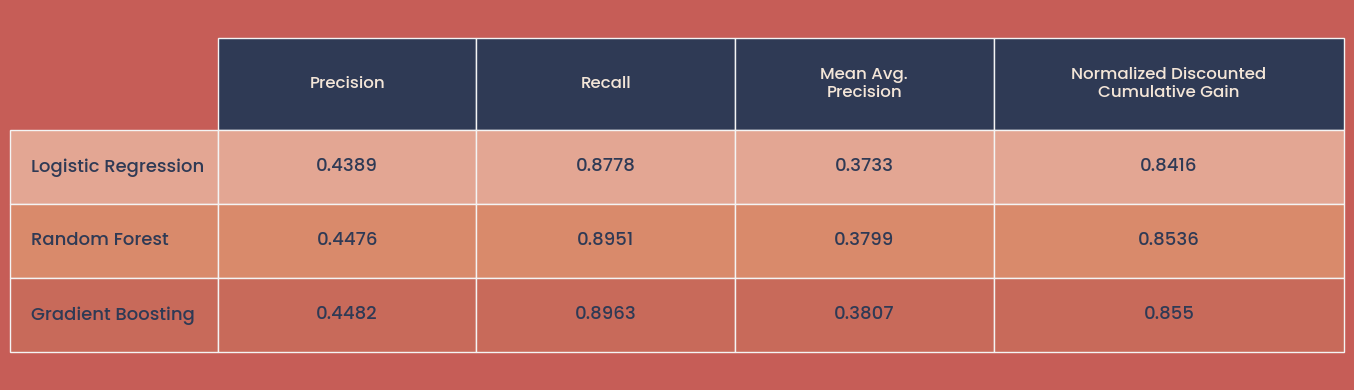

In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd

# ------------------------
# Load Poppins font
# ------------------------
fm.fontManager.addfont("Poppins-Medium.ttf")
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.weight"] = "medium"

# ------------------------
# Data
# ------------------------
df = pd.DataFrame({
    "Precision":  [0.4389, 0.4476, 0.4482],
    "Recall":  [0.8778, 0.8951, 0.8963],
    "Mean Avg.\nPrecision":[0.3733, 0.3799, 0.3807],
    "Normalized Discounted\nCumulative Gain":[0.8416,0.8536,0.8550],
}, index=["Logistic Regression", "Random Forest", "Gradient Boosting"])

# ------------------------
# Colors
# ------------------------
header_bg = "#2F3A55"     # dark navy
header_text = "#F4E6D8"   # cream

row1 = "#E3A693"          # light terracotta
row2 = "#D98A6B"          # darker terracotta
highlight_row = "#C86A5A" # highlight color for Gradient Boosting row
body_text = "#2F3A55"     # navy

border_color = "#F4F4F4"
background = "#c65d57"    # updated background color

# ------------------------
# Build table
# ------------------------
def plot_metrics_table(df):
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.axis("off")

    # Row striping, but override Gradient Boosting row
    cell_colors = []
    for i, idx in enumerate(df.index):
        if idx == "Gradient Boosting":
            # Highlight entire row
            cell_colors.append([highlight_row] * len(df.columns))
        else:
            row_color = row1 if i % 2 == 0 else row2
            cell_colors.append([row_color] * len(df.columns))

    # Create table
    table = ax.table(
        cellText=df.round(4).values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellColours=cell_colors,
        colColours=[header_bg] * len(df.columns),
        cellLoc="center",
        colLoc="center",
        loc="center"
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(13)

    # Adjust column widths - make last column wider for long text
    for c in range(len(df.columns)):
        width = 0.28 if c < len(df.columns) - 1 else 0.38
        for r in range(len(df) + 1):
            table.get_celld()[(r, c)].set_width(width)

    for (row, col), cell in table.get_celld().items():

        # Header
        if row == 0:
            cell.set_text_props(color=header_text, fontsize=12, fontweight="semibold")
            cell.set_facecolor(header_bg)
            cell.set_edgecolor(border_color)
            cell.set_height(0.25)
            continue

        # Row labels (model names)
        if col == -1:
            cell.set_text_props(color=body_text, fontweight="medium", fontsize=13)
            cell.set_edgecolor(border_color)
            # Set the row label background to match its row
            if df.index[row-1] == "Gradient Boosting":
                cell.set_facecolor(highlight_row)
            else:
                cell.set_facecolor(cell_colors[row-1][0])
            cell.set_height(0.2)
            continue

        # Body cells
        cell.set_text_props(color=body_text, fontsize=13)
        cell.set_edgecolor(border_color)
        cell.set_height(0.2)

    fig.patch.set_facecolor(background)
    plt.tight_layout()
    plt.show()


# ------------------------
# Render
# ------------------------
plot_metrics_table(df)